In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/Users/bytedance/MLTrader-Research/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from research.orderbook_strategies.utils.product_info import product_info
import itertools
import pandas as pd
from collections import OrderedDict
import functools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')
import scipy
from scipy.stats import norm
import seaborn as sns
product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]
ATR_FILTER = 0.02
MAX_SPREAD_RATIO = 1.1

In [5]:
f1 = factors.factor_last_buy_value_ratio_cross_more_positions()
f3 = factors.factor_large_trade_ratio()
f4 = factors.factor_last_buy_count_ratio()
f5 = factors.factor_last_buy_value_ratio()
# signals = [f1, f2, f3, f4, f5]
signals = [f1, f5]
# signals = [f3, f4]

In [7]:
# %%time
# 构造因子

for product in product_list:
    date_list = helper.get_dates_list(product)
    print(product)
    helper.parLapply(date_list, 
                    factor_analysis.merge_metric_trades_and_construct_indicators,
                    product=product,
                    signal_list=[f1, f5], 
                    overwrite=True,)



OPUSDT
BTCUSDT
yst metrics is None for  BTCUSDT 2023-07-25
metric data is None for  BTCUSDT 2023-07-25
tmr_metrics is None for  BTCUSDT 2023-07-25
ETHUSDT
APTUSDT
1000PEPEUSDT


In [8]:
# for product in product_list:
#     for signal in [f1, f2, f3, f4, f5]:
#         for period in signal.params['period']:
#             name = signal.factor_name
#             name = name.replace("period", str(period))
#             dates = helper.get_dates_list(product, signal_name=name)
#             if len(helper.date_is_continuous(dates)) > 0:
#                 print(product, name, period)
#                 print(helper.date_is_continuous(dates))

In [3]:
# 脚本现在开始
periods = np.power(2, range(10, 15))
signal_name_format = 'trade.buy_power.{period}'

In [10]:
all_product_signal_periods = {}
for period in periods:
    signal_name = signal_name_format.format(period=period)
    all_product_signal_periods[period] = helper.get_signal_data(product_list, signal_name)
    
tick_ret = helper.get_field_data(product_list, "ret")

no file found for BTCUSDT trade.buy_power.1024 2023-07-24
no file found for BTCUSDT trade.buy_power.1024 2023-07-25
no file found for BTCUSDT trade.buy_power.1024 2023-07-26
no file found for BTCUSDT trade.buy_power.2048 2023-07-24
no file found for BTCUSDT trade.buy_power.2048 2023-07-25
no file found for BTCUSDT trade.buy_power.2048 2023-07-26
no file found for BTCUSDT trade.buy_power.4096 2023-07-24
no file found for BTCUSDT trade.buy_power.4096 2023-07-26
no file found for BTCUSDT trade.buy_power.4096 2023-07-25
no file found for BTCUSDT trade.buy_power.8192 2023-07-24
no file found for BTCUSDT trade.buy_power.8192 2023-07-25
no file found for BTCUSDT trade.buy_power.8192 2023-07-26
no file found for BTCUSDT trade.buy_power.16384 2023-07-26no file found for BTCUSDT trade.buy_power.16384 2023-07-25

no file found for BTCUSDT trade.buy_power.16384 2023-07-24


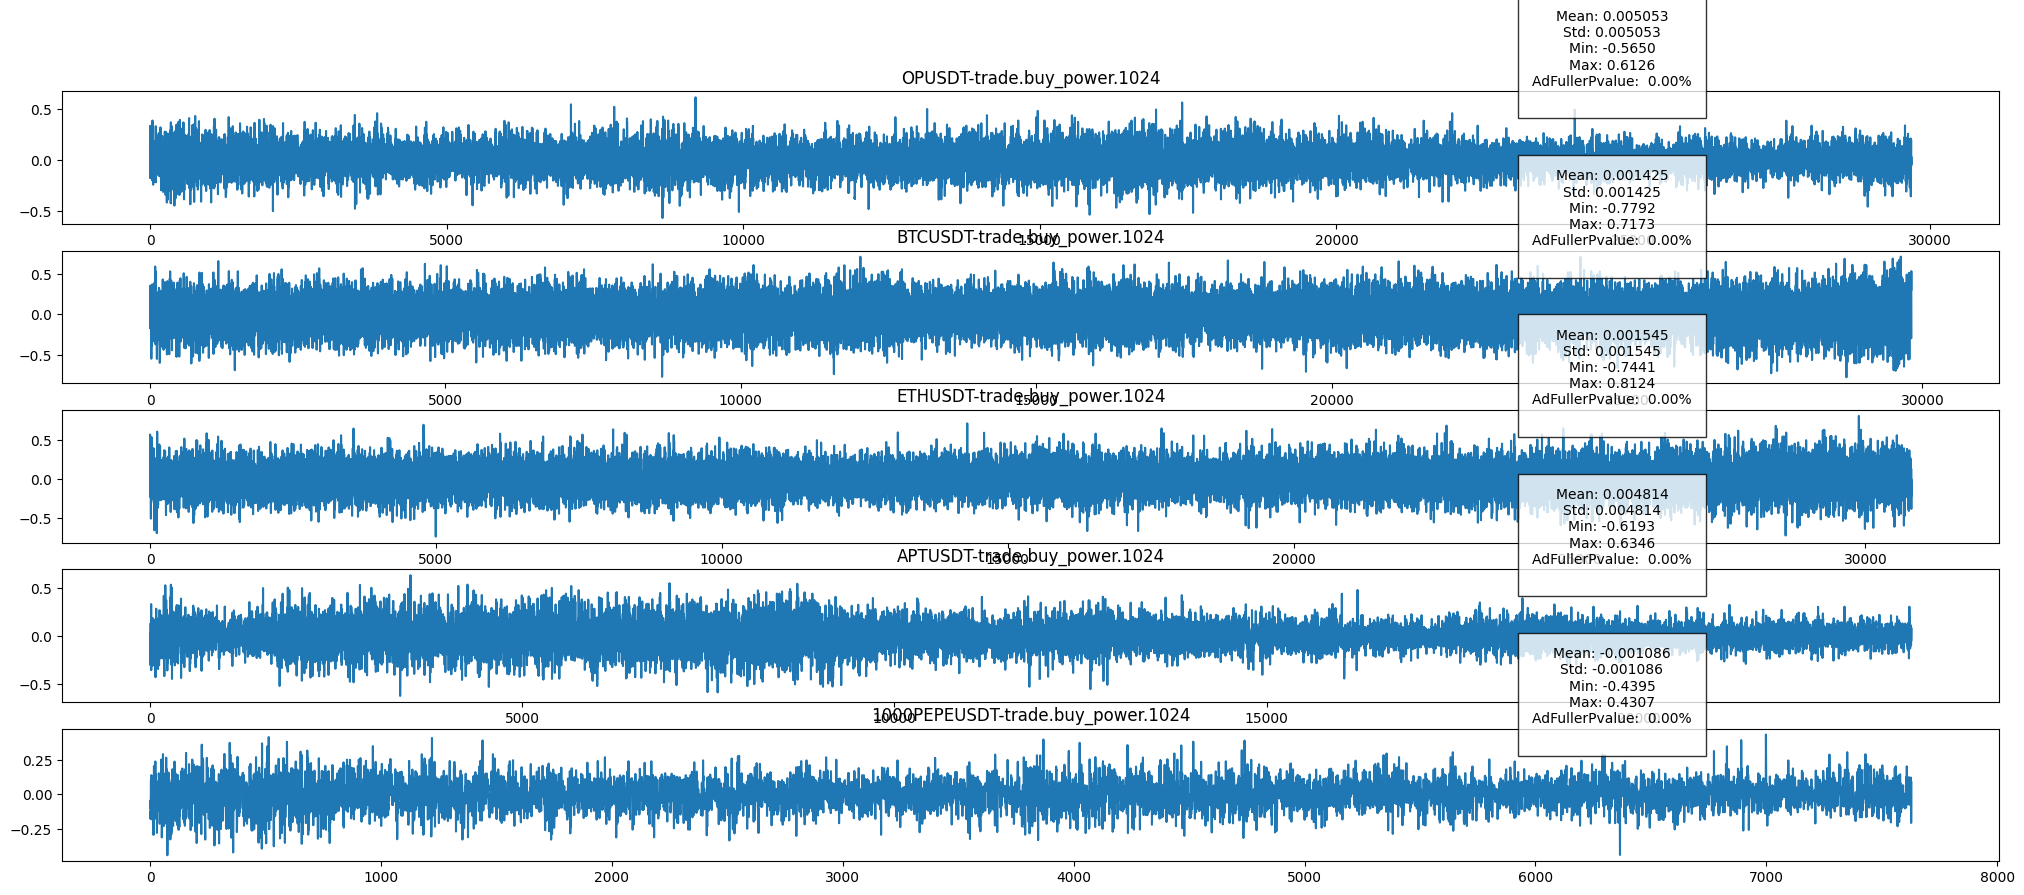

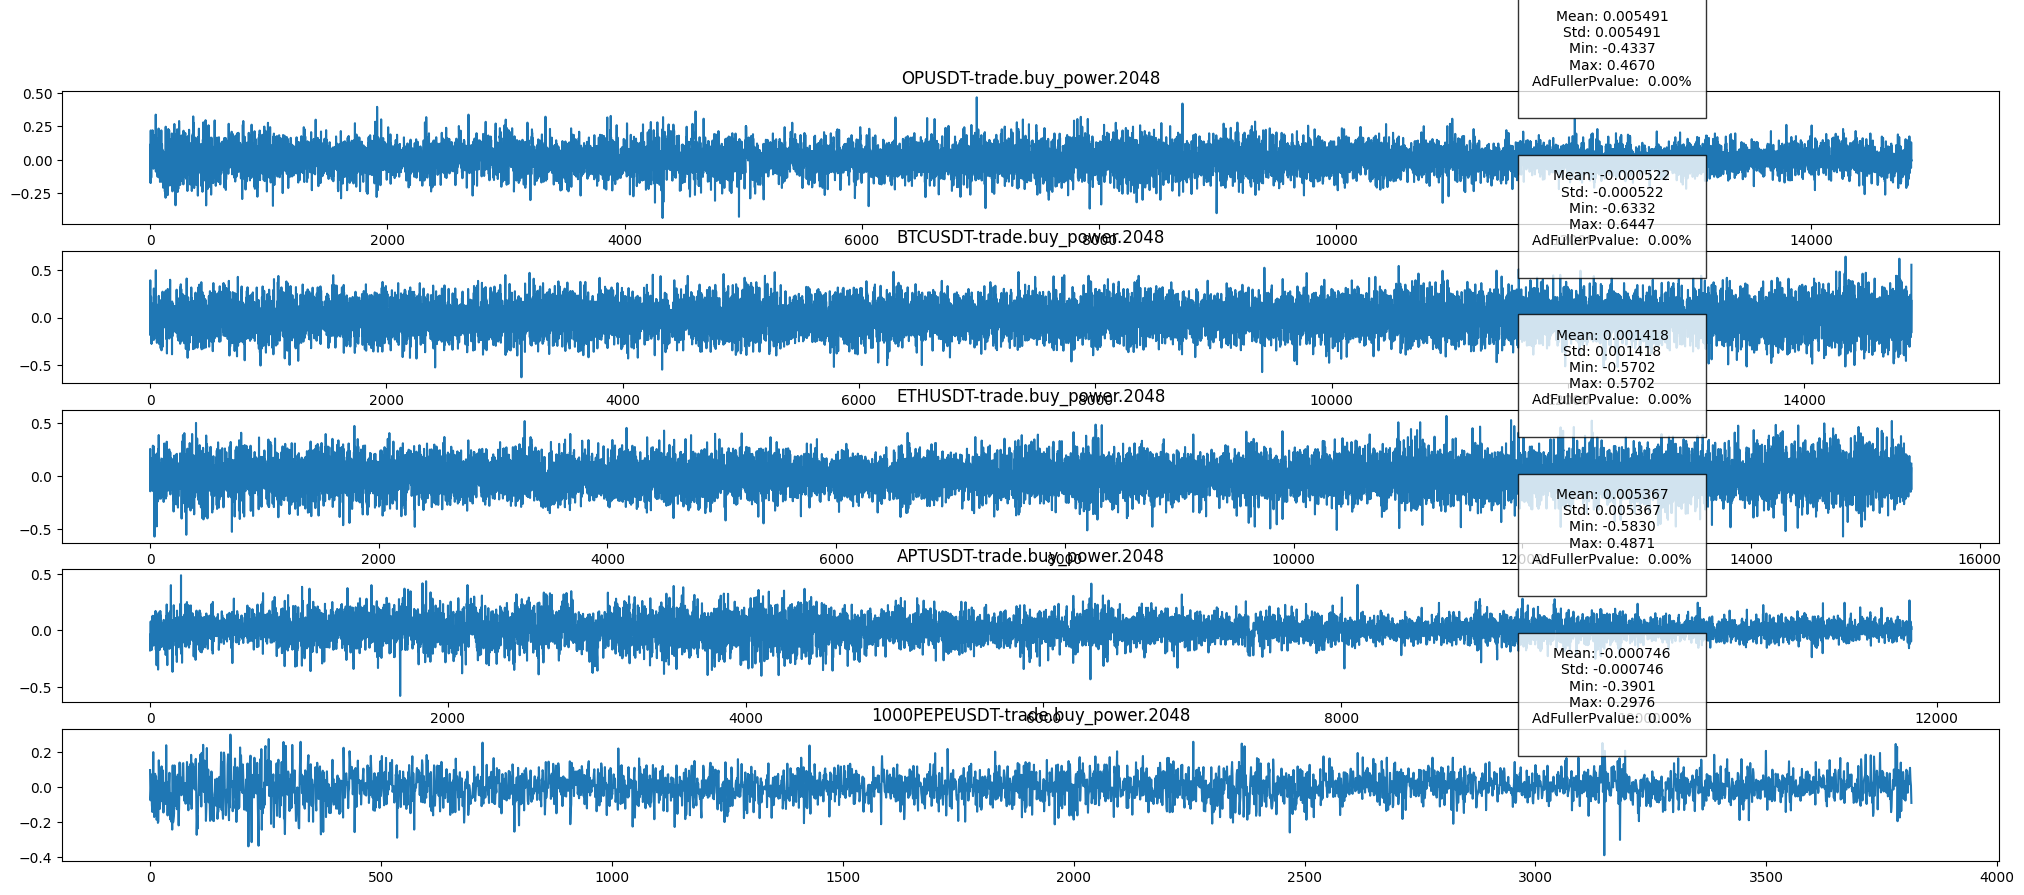

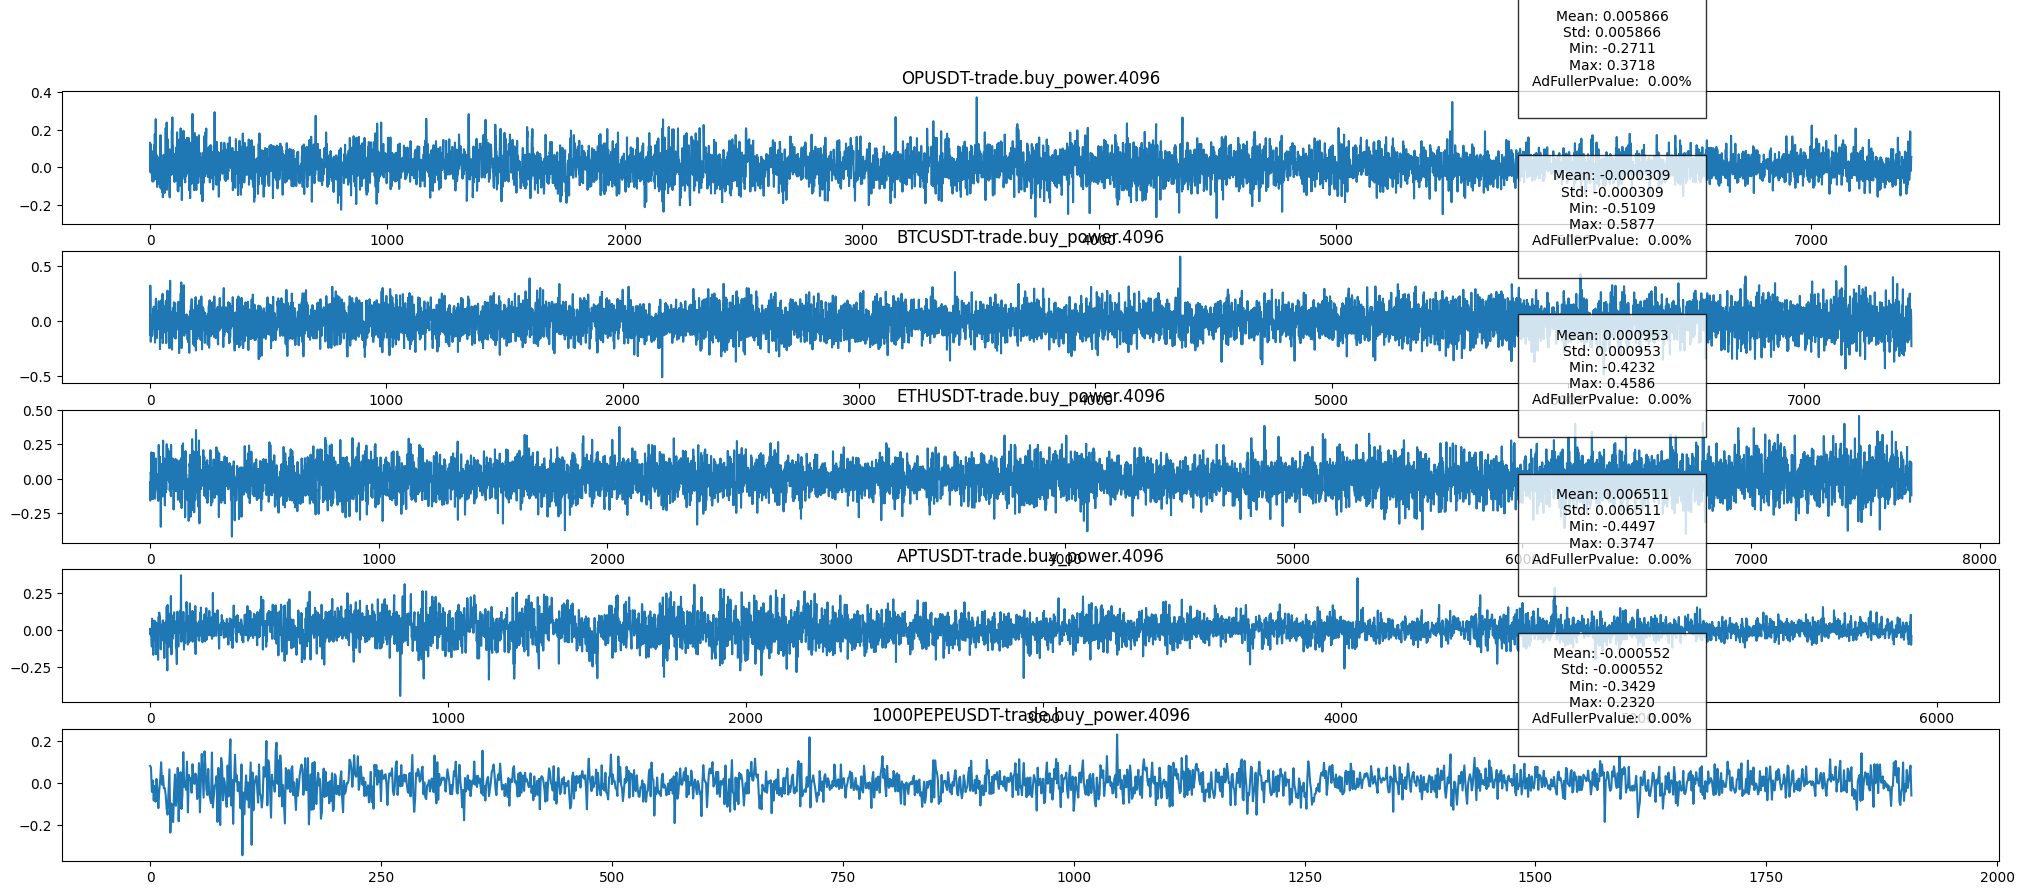

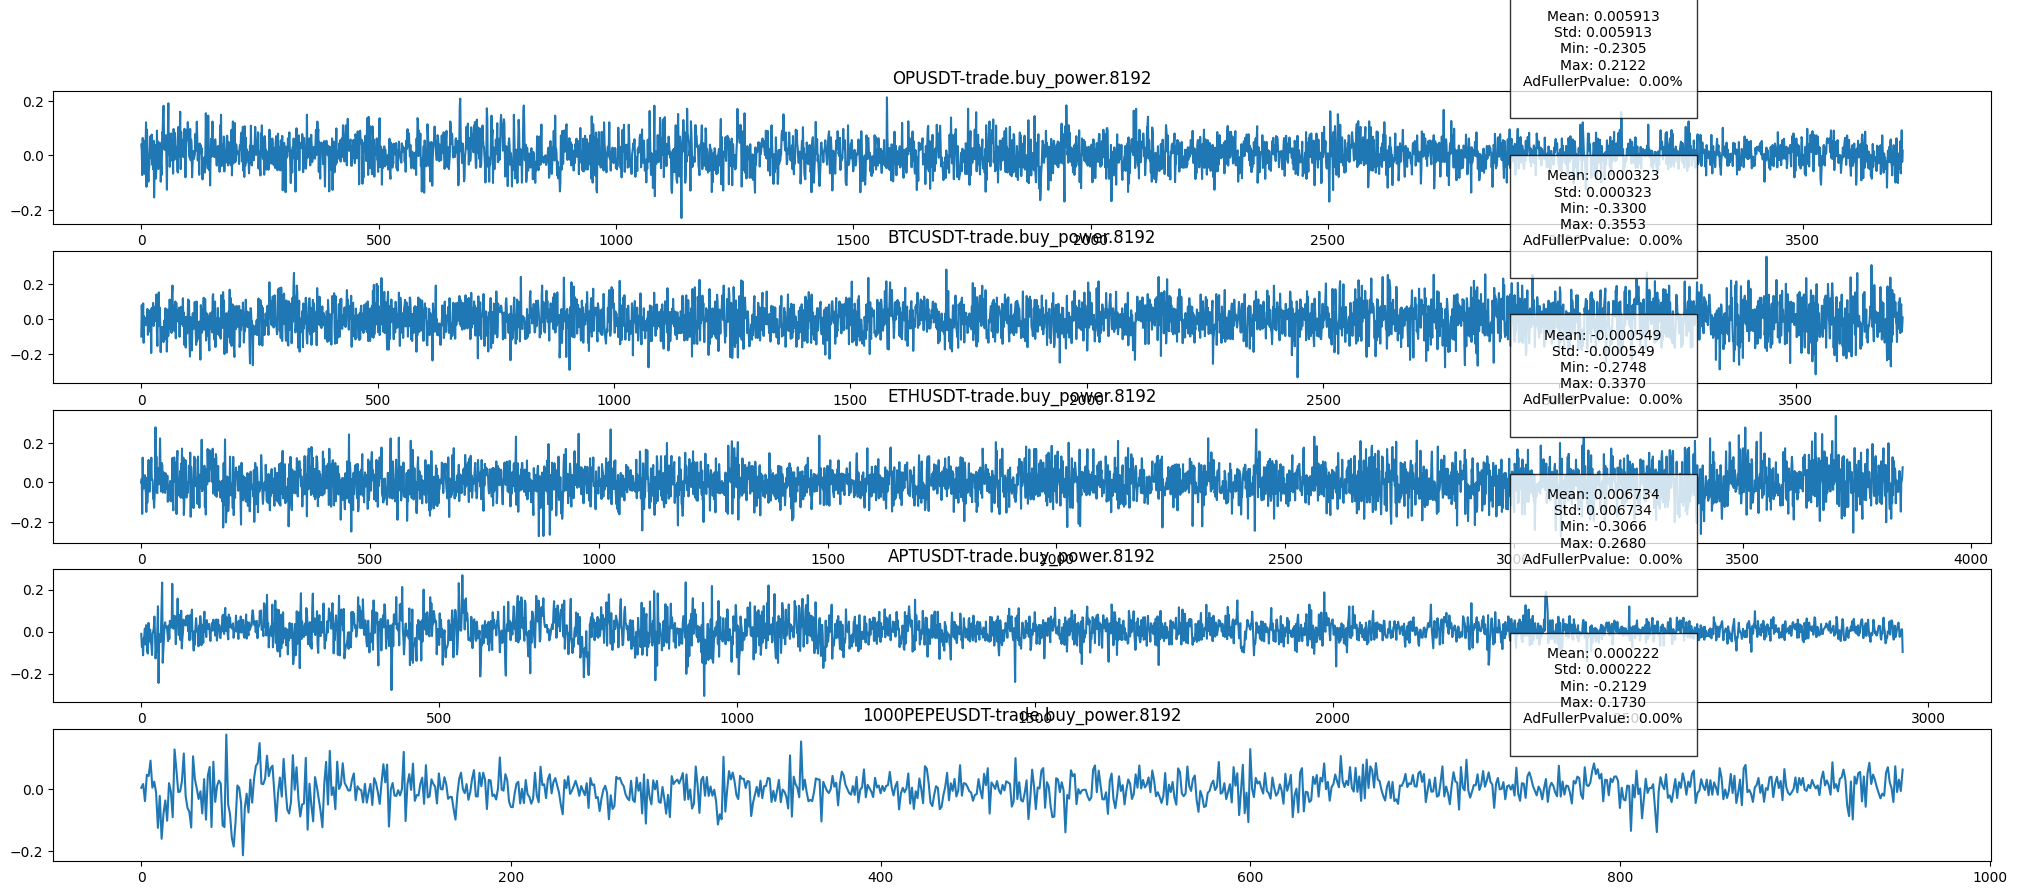

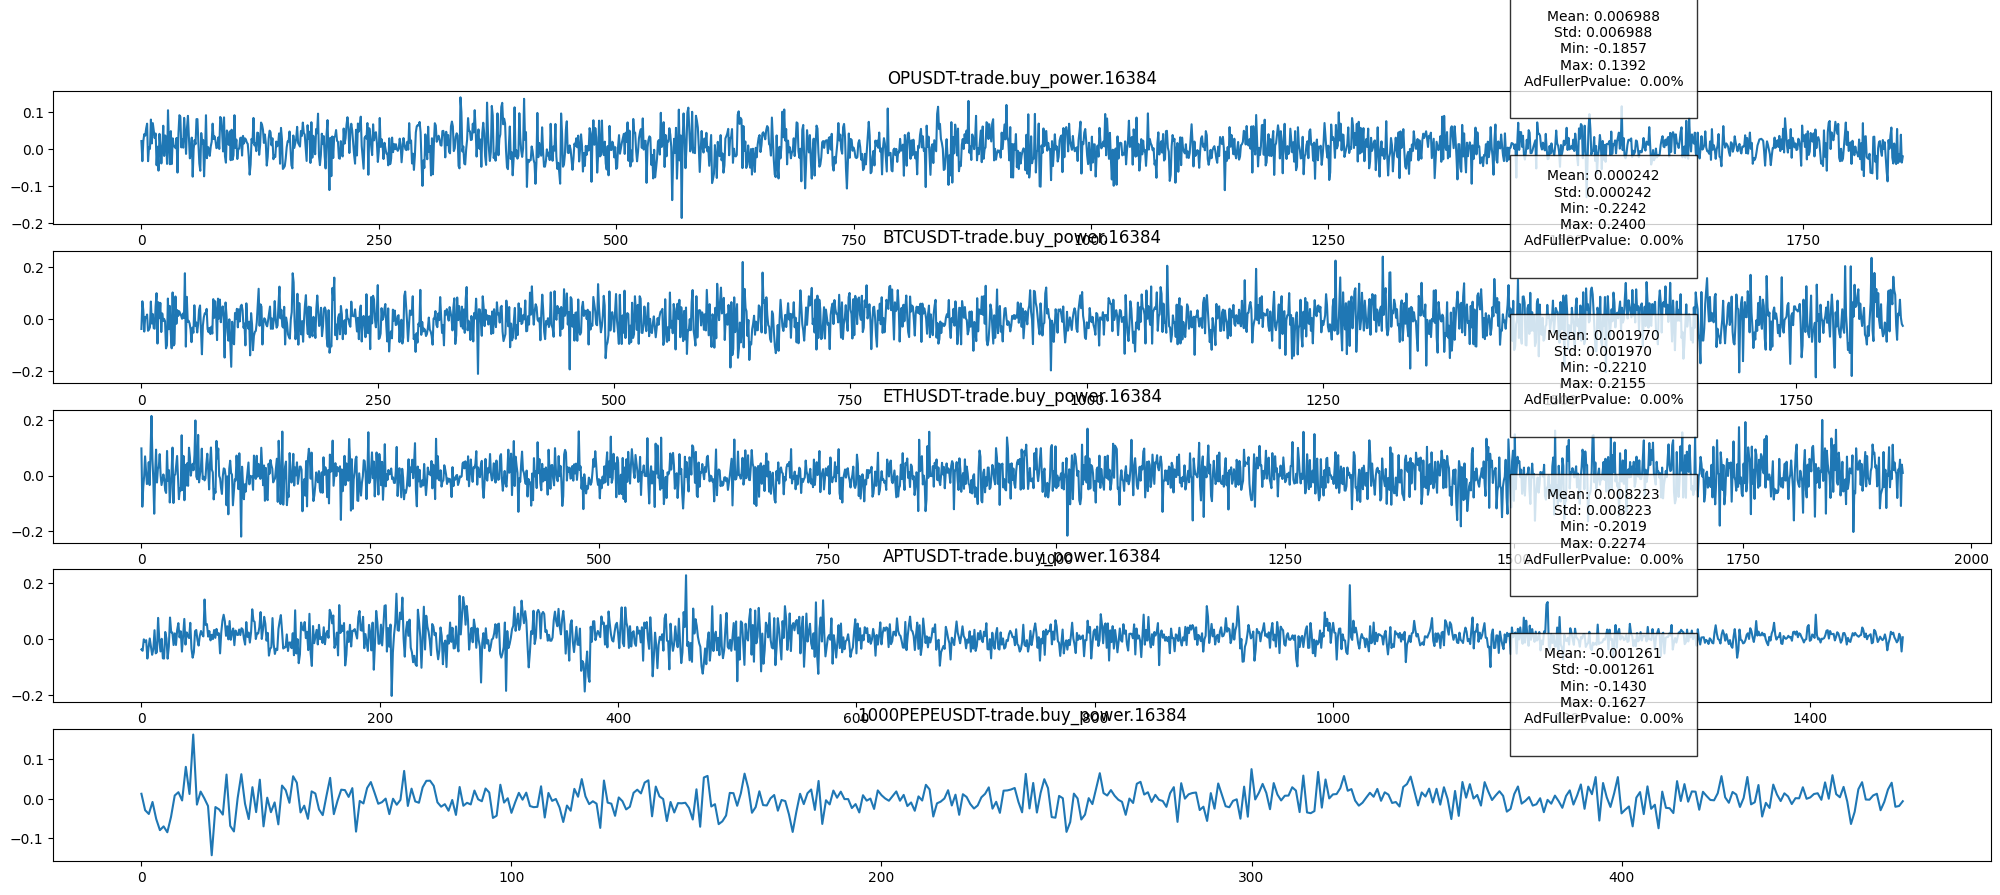

In [11]:
import statsmodels.tsa.stattools as ts
for period in periods:
    f, axes = plt.subplots(len(product_list), 1, figsize=(5 * len(product_list), 10))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        
        T = len(arr)

        arr = arr[np.arange(0, T, period)]
        axes[i].plot(arr)
        axes[i].set_title(product + "-" + signal_name)
        _, p_val, _, _, _ = ts.adfuller(arr, maxlag=int(pow(len(arr)-1,(1/3))), regression='ct', autolag=None)
        
        mean = np.nanmean(arr)
        std = np.nanmean(arr)
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        summary_text = f"Mean: {mean:.6f}\nStd: {std:.6f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}\nAdFullerPvalue: {p_val: .2%}\n"
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

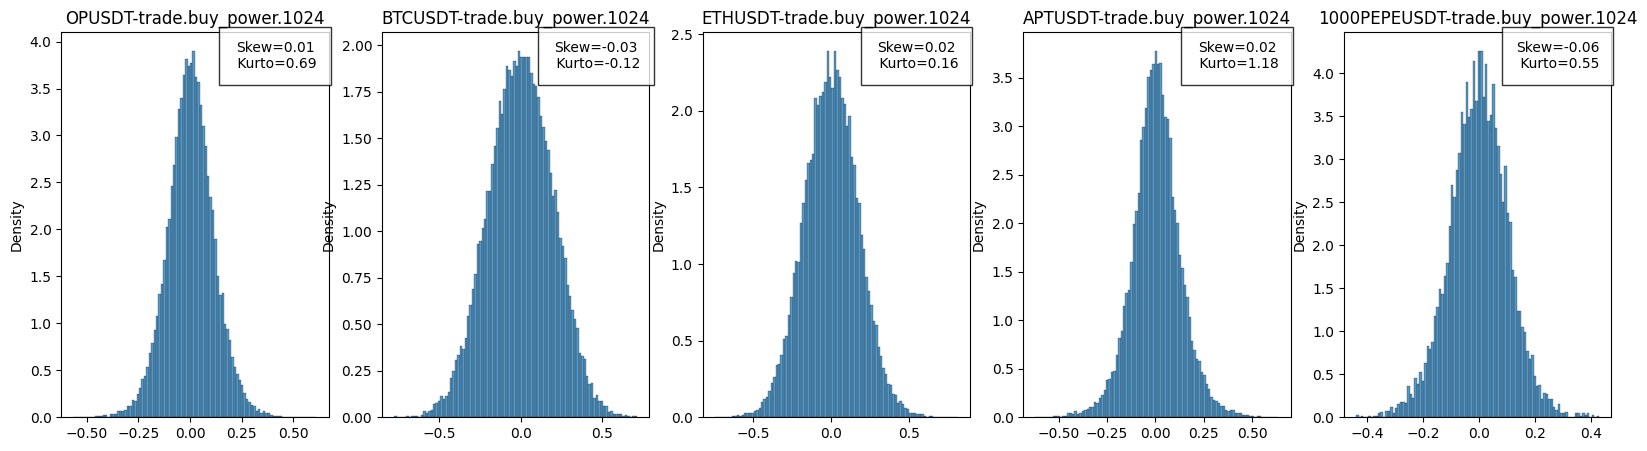

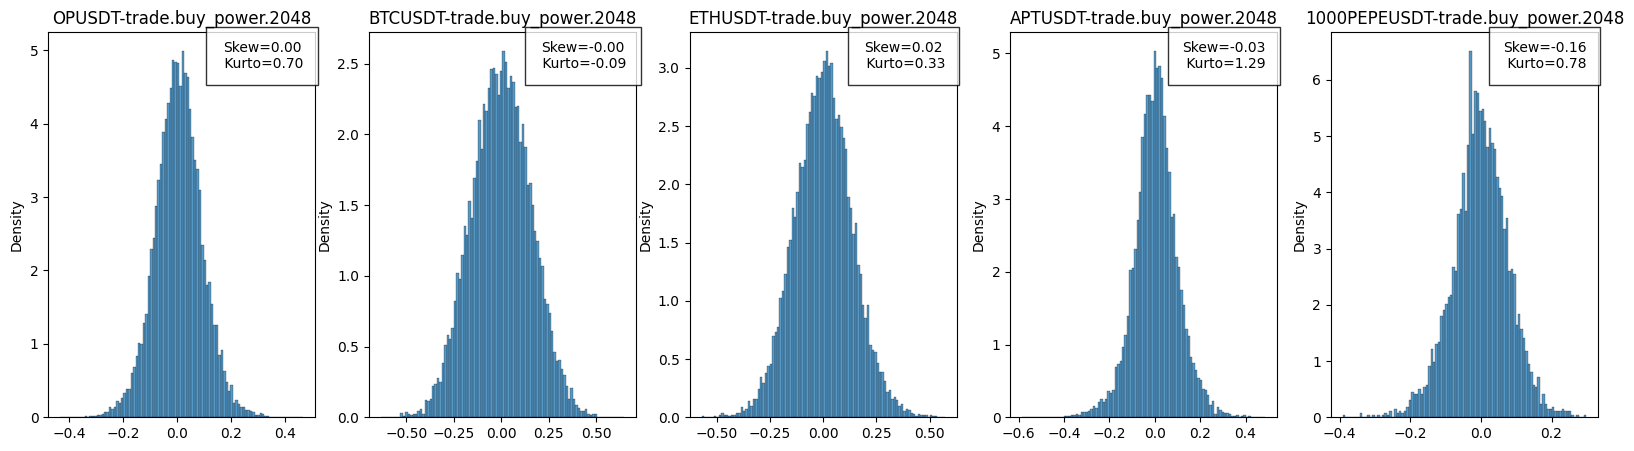

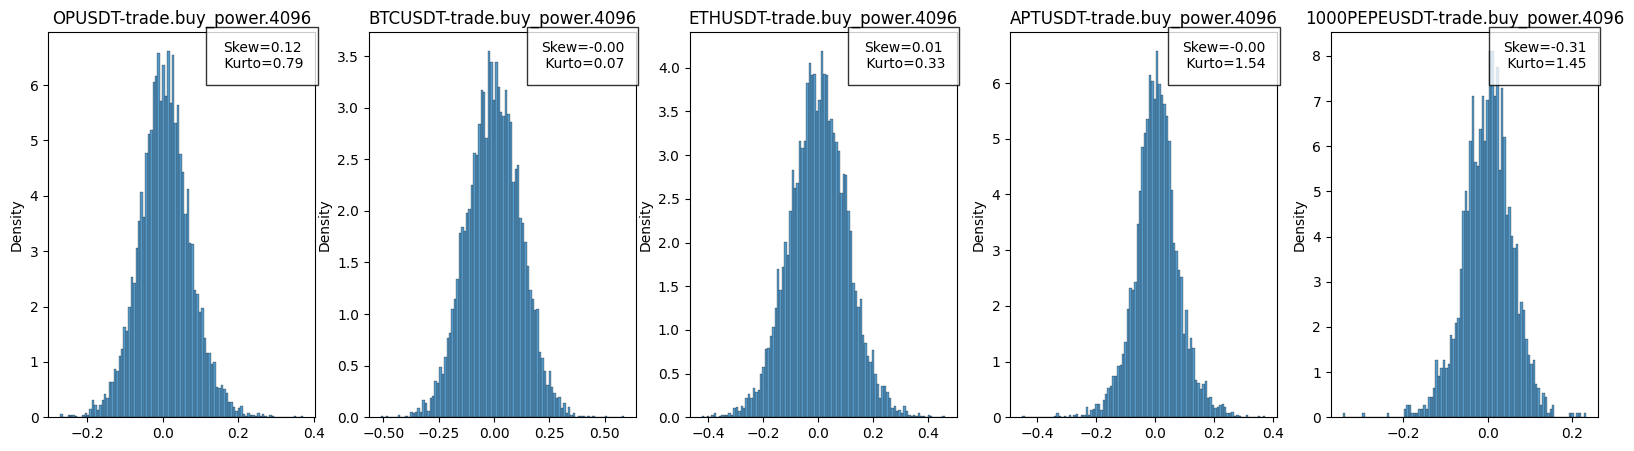

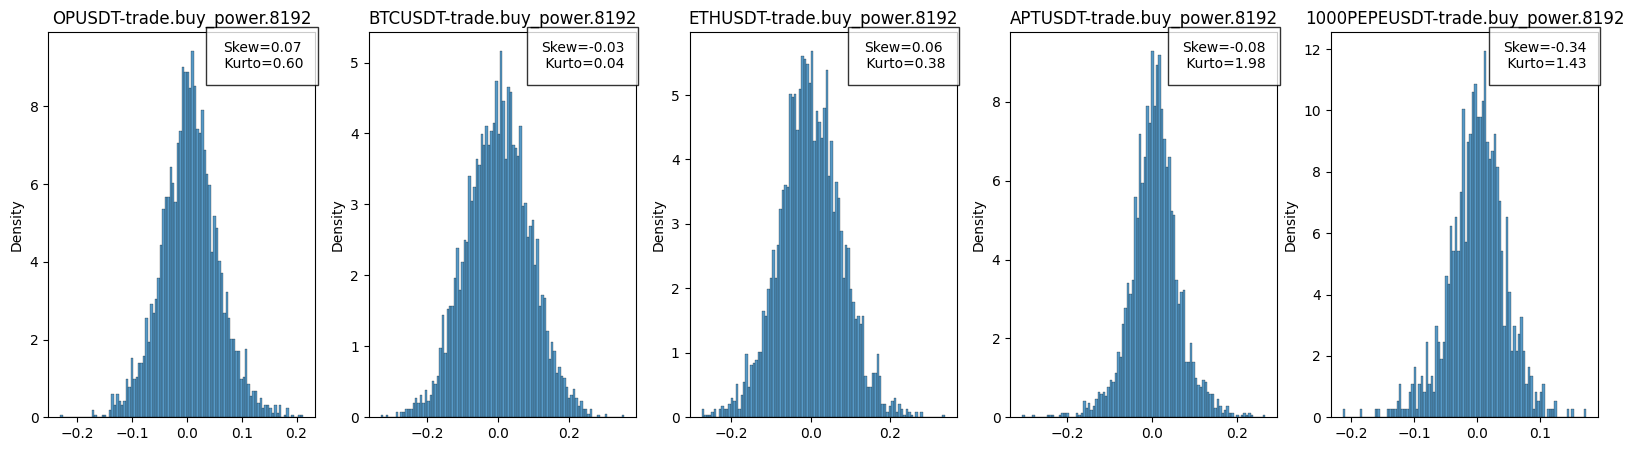

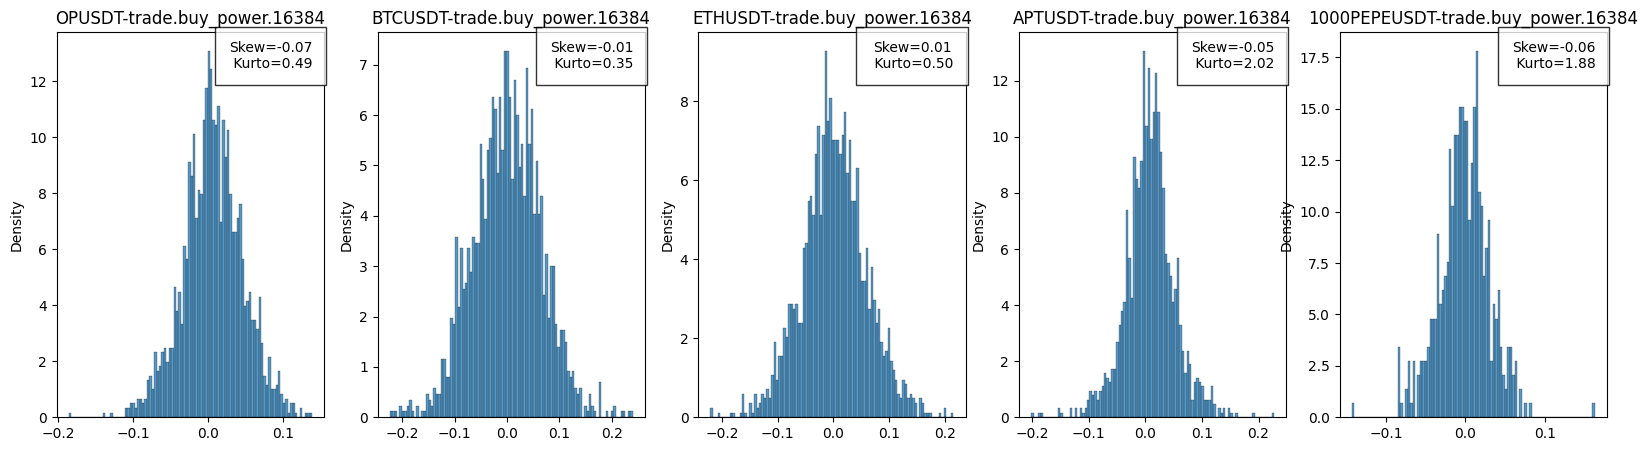

In [12]:
for period in periods:
    f, axes = plt.subplots(1, len(product_list), figsize=(20, 5))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        T = len(arr)
        arr = arr[np.arange(0, T, period)]
        skew = scipy.stats.skew(arr)
        kurto = scipy.stats.kurtosis(arr)
        summary_text = f"Skew={skew:.2f}\n Kurto={kurto:.2f}"
        # Plot the empirical histogram
        sns.histplot(arr, kde=False, bins=100, stat='density', label='Empirical', ax=axes[i])

        # # Fit a normal distribution to the data
        # mean, std = norm.fit(data)

        # # Generate values for the estimated normal distribution
        # x = np.linspace(min(data), max(data), 100)
        # y = norm.pdf(x, mean, std)

        # axes[i].plot(x, y, label='Estimated', color='red')
        axes[i].set_title(product + "-" + signal_name)
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

In [4]:
trades_signal_period = [signal_name_format.format(period=period) for period in periods]
results = factor_analysis.get_signal_performance_result(trades_signal_period, "signal_result_with_atr", product_list, 1e-4, 1)

trend_res = results['trend.signal.stat']
reve_res = results["reverse.signal.stat"]
signal_trend_res = trend_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']
signal_rever_res = reve_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']

trend_signals = signal_trend_res[(signal_trend_res - signal_rever_res) > 0].index
reverse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) < 0].index
nouse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) == 0].index

print("#trend={}, #reverse={}, #nouse={}".format(len(trend_signals), len(reverse_signals), len(nouse_signals)))

merge_res = pd.concat([trend_res.loc[np.isin(trend_res['signal'], trend_signals)], 
                       reve_res.loc[np.isin(reve_res['signal'], reverse_signals)]], 
                      axis=0)

display(merge_res.sort_values(by='trainSharpe', ascending=False))

no good product for trade.buy_power.1024 trend
no good product for trade.buy_power.1024 reverse
no good product for trade.buy_power.2048 trend
no good product for trade.buy_power.2048 reverse
no good product for trade.buy_power.4096 trend
no good product for trade.buy_power.4096 reverse
no good product for trade.buy_power.8192 trend
no good product for trade.buy_power.8192 reverse
no good product for trade.buy_power.16384 trend
no good product for trade.buy_power.16384 reverse


KeyError: "None of [Index(['signal', 'trainSharpe'], dtype='object')] are in the [columns]"

In [5]:
res = []
df = pd.DataFrame()
bt_stra = "signal_result_with_atr"
for product in product_list:
    for period in periods:
        for direction in ["reverse", "trend"]:
            reverse = 1 if direction == "trend" else -1
            name = signal_name_format.format(period=period)
            p = (
                    helper.SIGNAL_RESULTS_PATH
                    / bt_stra
                    / f"{product}.{name}.{direction}.pkl"
                )
            signal_stat = helper.load(p)
            if signal_stat is None:
                print(f"{p} not found ")
                continue
            
            if tuple(signal_stat.keys())[0] != "train.stat":
                raise ValueError("wrong key")
            final_result_train, final_result_test = (
                signal_stat["train.stat"]["final_result"],
                signal_stat["test.stat"]["final_result"],
            )

            final_result_train["is_train"] = True
            final_result_train["reverse"] = reverse
            final_result_train["bt_stra"] = bt_stra

            final_result_test["is_train"] = False
            final_result_test["bt_stra"] = bt_stra
            final_result_test["reverse"] = reverse
            df = pd.concat([df, final_result_train, final_result_test], axis=0)